Gabriel Christopher Tanod - 2602142413

Nomor 2

In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import save_image
import numpy as np
from scipy.linalg import sqrtm

# Generator Network
class Generator(nn.Module):
    def __init__(self, noise_dim, num_classes, img_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.label_embed = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(noise_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, img_size**2),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_embed(labels)
        x = torch.cat((noise, label_embedding), dim=1)
        img = self.model(x)
        return img.view(-1, 1, self.img_size, self.img_size)

# Baseline Discriminator Network
class DiscriminatorBaseline(nn.Module):
    def __init__(self, num_classes, img_size):
        super(DiscriminatorBaseline, self).__init__()
        self.img_size = img_size
        self.label_embed = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(img_size**2 + num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        img_flat = img.view(-1, self.img_size**2)
        label_embedding = self.label_embed(labels)
        x = torch.cat((img_flat, label_embedding), dim=1)
        return self.model(x)


In [130]:
# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise_dim = 100
num_classes = 2  # Changed from 10 to 2
img_size = 28
batch_size = 128
epochs = 40
lr = 0.0002

from scipy.linalg import sqrtm

# FID Calculation Function
def calculate_fid(real_images, fake_images, device):
    # Pretrained InceptionV3 Model
    inception = models.inception_v3(pretrained=True, transform_input=False).to(device)
    inception.eval()

    # Feature extractor for InceptionV3
    def get_features(images):
        with torch.no_grad():
            images = images.to(device)
            # Ensure images have 3 channels (convert grayscale to RGB)
            if images.size(1) == 1:  # Grayscale (1 channel)
                images = images.repeat(1, 3, 1, 1)  # Convert to 3 channels by repeating
            # Inception expects images with size [batch_size, 3, 299, 299]
            images = torch.nn.functional.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
            features = inception(images)
            # The output is of shape [batch_size, 2048]
            return features

    # Get features for real and fake images
    real_features = get_features(real_images)
    fake_features = get_features(fake_images)

    # Calculate the mean and covariance of the features
    real_mean = torch.mean(real_features, dim=0)
    fake_mean = torch.mean(fake_features, dim=0)
    real_cov = torch.cov(real_features.T)
    fake_cov = torch.cov(fake_features.T)

    # Move to CPU for sqrtm calculation
    real_cov_cpu = real_cov.cpu().numpy()
    fake_cov_cpu = fake_cov.cpu().numpy()

    # Compute the Fréchet Distance (FID)
    diff = real_mean - fake_mean
    cov_sqrt, _ = sqrtm(real_cov_cpu @ fake_cov_cpu, disp=False)
    
    # Ensure that the result of sqrtm is real by taking the real part
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real
    
    fid = torch.norm(diff) + torch.trace(real_cov + fake_cov - 2 * torch.from_numpy(cov_sqrt).to(device))

    return fid.item()


    
# Initialize networks
generator = Generator(noise_dim, num_classes, img_size).to(device)
discriminator = DiscriminatorBaseline(num_classes, img_size).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss()


In [131]:
# Data loading
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load Fashion MNIST and filter for classes 0 (T-shirt/top) and 1 (Trouser)
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# Create mask for classes 0 and 1
mask = (train_dataset.targets == 0) | (train_dataset.targets == 1)
train_dataset.data = train_dataset.data[mask]
train_dataset.targets = train_dataset.targets[mask]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Epoch [1/40] FID: 647.8306
Epoch [1/40] Loss D: 0.1564 Loss G: 3.7286
Epoch [2/40] Loss D: 0.1199 Loss G: 4.3980
Epoch [3/40] Loss D: 0.1768 Loss G: 4.4909
Epoch [4/40] Loss D: 0.1393 Loss G: 3.4554
Epoch [5/40] Loss D: 0.2560 Loss G: 3.2015
Epoch [6/40] FID: 706.7316
Epoch [6/40] Loss D: 0.1864 Loss G: 3.9909
Epoch [7/40] Loss D: 0.1813 Loss G: 5.7957
Epoch [8/40] Loss D: 0.3062 Loss G: 2.8932
Epoch [9/40] Loss D: 0.1659 Loss G: 3.2537
Epoch [10/40] Loss D: 0.1873 Loss G: 4.0615
Epoch [11/40] FID: 749.5286
Epoch [11/40] Loss D: 0.2039 Loss G: 4.0973
Epoch [12/40] Loss D: 0.2805 Loss G: 4.0989
Epoch [13/40] Loss D: 0.2101 Loss G: 3.3639
Epoch [14/40] Loss D: 0.3058 Loss G: 4.9628
Epoch [15/40] Loss D: 0.2152 Loss G: 3.5247
Epoch [16/40] FID: 745.0729
Epoch [16/40] Loss D: 0.4202 Loss G: 5.4980
Epoch [17/40] Loss D: 0.3540 Loss G: 3.4861
Epoch [18/40] Loss D: 0.2918 Loss G: 3.4628
Epoch [19/40] Loss D: 0.2511 Loss G: 3.7541
Epoch [20/40] Loss D: 0.2708 Loss G: 4.7519
Epoch [21/40] FID: 

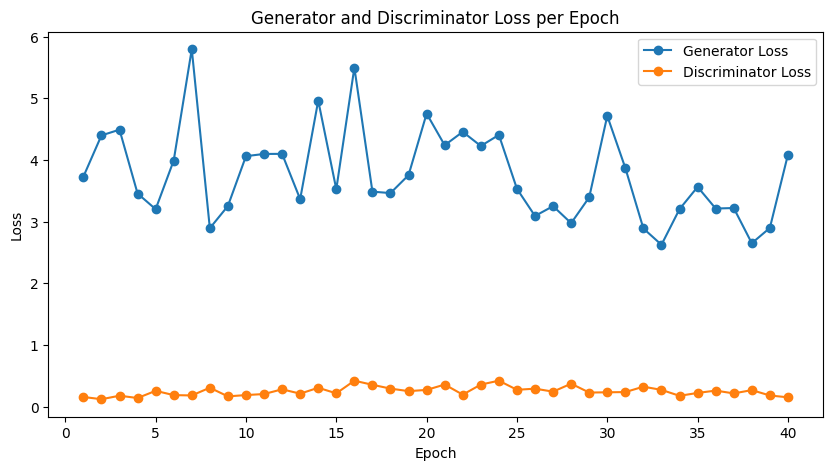

In [133]:
# Initialize lists to store losses
gen_losses = []
disc_losses = []

# Training loop
for epoch in range(epochs):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    num_batches = 0
    
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size = imgs.size(0)
        
        # Adversarial ground truths
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        
        # Real images
        real_loss = loss_fn(discriminator(imgs.to(device), labels.to(device)), real)
        
        # Fake images
        noise = torch.randn(batch_size, noise_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        gen_imgs = generator(noise, gen_labels)
        fake_loss = loss_fn(discriminator(gen_imgs.detach(), gen_labels), fake)
        
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = loss_fn(discriminator(gen_imgs, gen_labels), real)
        g_loss.backward()
        optimizer_G.step()

        # Accumulate losses
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()
        num_batches += 1

    # Calculate average losses for the epoch
    avg_d_loss = epoch_d_loss / num_batches
    avg_g_loss = epoch_g_loss / num_batches
    disc_losses.append(avg_d_loss)
    gen_losses.append(avg_g_loss)

    # FID Calculation
    if epoch % 5 == 0:
        with torch.no_grad():
            real_images = imgs.to(device)
            noise = torch.randn(batch_size, noise_dim).to(device)
            gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
            gen_imgs = generator(noise, gen_labels)
            fid = calculate_fid(real_images, gen_imgs, device)
            print(f"Epoch [{epoch+1}/{epochs}] FID: {fid:.4f}")

    print(f"Epoch [{epoch+1}/{epochs}] Loss D: {avg_d_loss:.4f} Loss G: {avg_g_loss:.4f}")

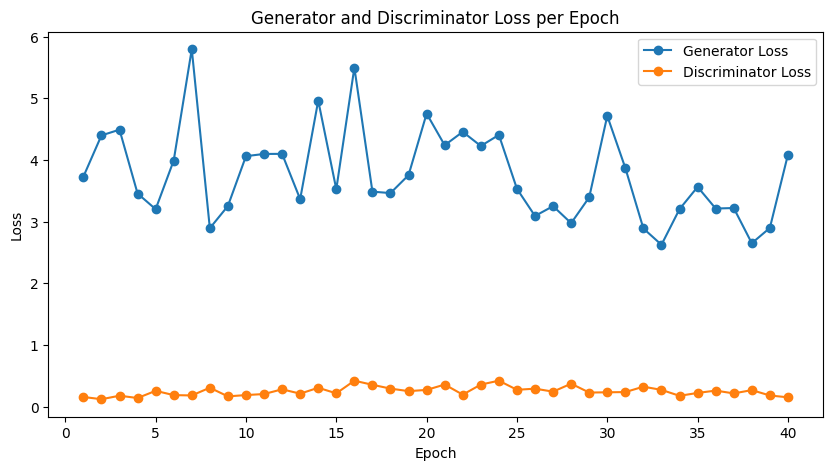

In [134]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), gen_losses, label="Generator Loss", marker='o')
plt.plot(range(1, epochs + 1), disc_losses, label="Discriminator Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Loss per Epoch")
plt.legend()
plt.show()

Modded Discriminator

In [135]:
# Baseline Discriminator Network
class ModdedDiscriminator(nn.Module):
    def __init__(self, num_classes, img_size):
        super(ModdedDiscriminator, self).__init__()
        self.img_size = img_size
        self.label_embed = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(img_size**2 + num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
        )

    def forward(self, img, labels):
        img_flat = img.view(-1, self.img_size**2)
        label_embedding = self.label_embed(labels)
        x = torch.cat((img_flat, label_embedding), dim=1)
        return self.model(x)

In [136]:
   
# Initialize networks
modded_generator = Generator(noise_dim, num_classes, img_size).to(device)
modded_discriminator = ModdedDiscriminator(num_classes, img_size).to(device)

# Optimizers
optimizer_G_2 = optim.Adam(modded_generator.parameters(), lr=lr)
optimizer_D_2 = optim.Adam(modded_discriminator.parameters(), lr=lr)
loss_fn_2 = nn.BCEWithLogitsLoss()

In [137]:
def calculate_fid(real_images, fake_images, device):
    # Pretrained InceptionV3 Model
    inception = models.inception_v3(pretrained=True, transform_input=False).to(device)
    inception.eval()

    # Feature extractor for InceptionV3
    def get_features(images):
        with torch.no_grad():
            images = images.to(device)
            # Ensure images have 3 channels (convert grayscale to RGB)
            if images.size(1) == 1:  # Grayscale (1 channel)
                images = images.repeat(1, 3, 1, 1)  # Convert to 3 channels by repeating
            # Inception expects images with size [batch_size, 3, 299, 299]
            images = torch.nn.functional.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
            features = inception(images)
            # The output is of shape [batch_size, 2048]
            return features

    # Get features for real and fake images
    real_features = get_features(real_images)
    fake_features = get_features(fake_images)

    # Calculate the mean and covariance of the features
    real_mean = torch.mean(real_features, dim=0)
    fake_mean = torch.mean(fake_features, dim=0)
    real_cov = torch.cov(real_features.T)
    fake_cov = torch.cov(fake_features.T)

    # Move to CPU for sqrtm calculation
    real_cov_cpu = real_cov.cpu().numpy()
    fake_cov_cpu = fake_cov.cpu().numpy()

    # Compute the Fréchet Distance (FID)
    diff = real_mean - fake_mean
    cov_sqrt, _ = sqrtm(real_cov_cpu @ fake_cov_cpu, disp=False)
    
    # Ensure that the result of sqrtm is real by taking the real part
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real
    
    fid = torch.norm(diff) + torch.trace(real_cov + fake_cov - 2 * torch.from_numpy(cov_sqrt).to(device))

    return fid.item()

In [138]:
# Initialize lists to store losses
gen_losses = []
disc_losses = []

# Training loop
for epoch in range(epochs):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    num_batches = 0
    
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size = imgs.size(0)
        
        # Adversarial ground truths
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        optimizer_D_2.zero_grad()
        
        # Real images
        real_loss = loss_fn_2(modded_discriminator(imgs.to(device), labels.to(device)), real)
        
        # Fake images
        noise = torch.randn(batch_size, noise_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        gen_imgs = modded_generator(noise, gen_labels)
        fake_loss = loss_fn_2(modded_discriminator(gen_imgs.detach(), gen_labels), fake)
        
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D_2.step()

        # Train Generator
        optimizer_G_2.zero_grad()
        g_loss = loss_fn_2(modded_discriminator(gen_imgs, gen_labels), real)
        g_loss.backward()
        optimizer_G_2.step()

        # Accumulate losses
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()
        num_batches += 1

    # Calculate average losses for the epoch
    avg_d_loss = epoch_d_loss / num_batches
    avg_g_loss = epoch_g_loss / num_batches
    disc_losses.append(avg_d_loss)
    gen_losses.append(avg_g_loss)

    # FID Calculation
    if epoch % 5 == 0:
        with torch.no_grad():
            real_images = imgs.to(device)
            noise = torch.randn(batch_size, noise_dim).to(device)
            gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
            gen_imgs = modded_generator(noise, gen_labels)
            fid = calculate_fid(real_images, gen_imgs, device)
            print(f"Epoch [{epoch+1}/{epochs}] FID: {fid:.4f}")

    print(f"Epoch [{epoch+1}/{epochs}] Loss D: {avg_d_loss:.4f} Loss G: {avg_g_loss:.4f}")

Epoch [1/40] FID: 627.1675
Epoch [1/40] Loss D: 0.3253 Loss G: 1.6613
Epoch [2/40] Loss D: 0.1485 Loss G: 6.8149
Epoch [3/40] Loss D: 0.3255 Loss G: 8.9574
Epoch [4/40] Loss D: 0.4494 Loss G: 3.9565
Epoch [5/40] Loss D: 0.2504 Loss G: 6.9481
Epoch [6/40] FID: 602.8530
Epoch [6/40] Loss D: 0.2373 Loss G: 7.2011
Epoch [7/40] Loss D: 0.3651 Loss G: 6.1942
Epoch [8/40] Loss D: 0.3892 Loss G: 6.6131
Epoch [9/40] Loss D: 0.3533 Loss G: 5.6261
Epoch [10/40] Loss D: 0.2622 Loss G: 6.1949
Epoch [11/40] FID: 640.0725
Epoch [11/40] Loss D: 0.3513 Loss G: 4.0927
Epoch [12/40] Loss D: 0.1872 Loss G: 2.7242
Epoch [13/40] Loss D: 0.1032 Loss G: 4.9214
Epoch [14/40] Loss D: 0.0261 Loss G: 6.0110
Epoch [15/40] Loss D: 0.9001 Loss G: 6.2081
Epoch [16/40] FID: 623.3342
Epoch [16/40] Loss D: 0.2464 Loss G: 4.5677
Epoch [17/40] Loss D: 0.3088 Loss G: 3.3552
Epoch [18/40] Loss D: 0.1300 Loss G: 3.3457
Epoch [19/40] Loss D: 0.1383 Loss G: 4.9410
Epoch [20/40] Loss D: 0.1084 Loss G: 5.7684
Epoch [21/40] FID: 

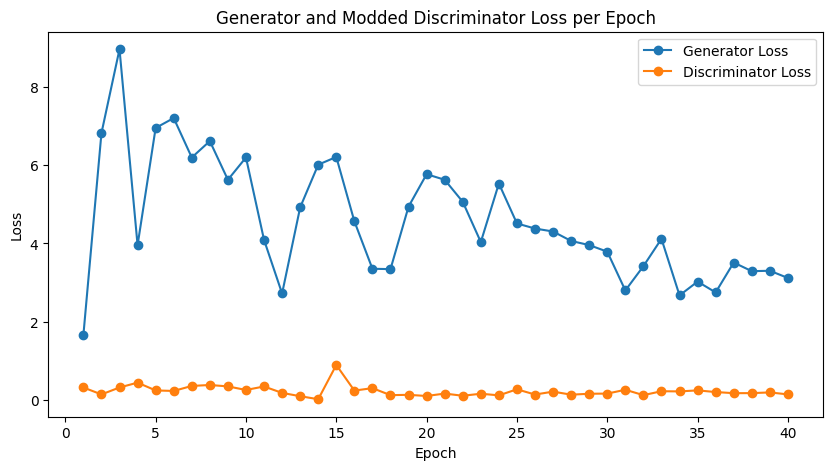

In [145]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), gen_losses, label="Generator Loss", marker='o')
plt.plot(range(1, epochs + 1), disc_losses, label="Discriminator Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator and Modded Discriminator Loss per Epoch")
plt.legend()
plt.show()